In [2]:
import time
from datasets import load_dataset

In [159]:
import pandas as pd
childrens_speech = pd.read_pickle('./asr_data/childrens_speech')
childrens_speech['duration'] = [len(audio) / 22500 for audio in childrens_speech['audio']]
# childrens_speech['duration'].describe()


(array([265., 159., 118.,  45.,  27.,   8.,  11.,   3.,   1.,   2.]),
 array([ 0.38497778,  1.62109333,  2.85720889,  4.09332444,  5.32944   ,
         6.56555556,  7.80167111,  9.03778667, 10.27390222, 11.51001778,
        12.74613333]),
 <BarContainer object of 10 artists>)

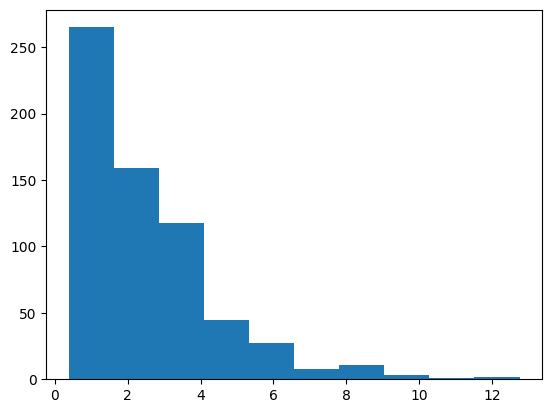

In [124]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(childrens_speech['duration'])

In [103]:
dataset = load_dataset(
    "hf-internal-testing/librispeech_asr_demo", "clean", split="validation")

Found cached dataset librispeech_asr_demo (/Users/ryanselesnik/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_demo/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


In [104]:
dataset[0]['audio']

{'path': '/Users/ryanselesnik/.cache/huggingface/datasets/downloads/extracted/dddb8d26f1729f34ebd711f0db4e4e5fdfad88bdf0ecdae63849475abd0d78f8/dev_clean/1272/128104/1272-128104-0000.flac',
 'array': array([0.00238037, 0.0020752 , 0.00198364, ..., 0.00042725, 0.00057983,
        0.0010376 ], dtype=float32),
 'sampling_rate': 16000}

In [50]:
childrens_speech.iloc[0:10]['audio']

0    [0.009646121, 0.021695968, 0.022539534, 0.0212...
1    [0.027527185, 0.032552492, 0.012983527, 0.0112...
2    [-0.03888016, -0.057698667, -0.045864653, -0.0...
3    [0.04435131, 0.06784426, 0.058827527, 0.077713...
4    [0.025824236, 0.029695712, 0.02606499, 0.03642...
5    [0.0076621133, 0.012323398, 0.015264143, 0.017...
6    [-0.014430652, -0.0126683, -0.0046059187, -0.0...
7    [0.0035915715, 0.008562879, 0.012892084, 0.014...
8    [-0.02447056, -0.031614304, -0.024095725, -0.0...
9    [-0.008480104, -0.011511586, -0.013792121, -0....
Name: audio, dtype: object

In [12]:
from transformers import pipeline
import whisper


def transcribe(model, audio):
    """
    Given a model transcribe audio to text

    args: 
        model: str specifiy either whisper or wav2vec2  
    
    """
    if 'wav' in model:
        model = pipeline(task='automatic-speech-recognition',
                     model='facebook/wav2vec2-large-960h')
        text = model(audio) 
        return text
    elif '.en' in model:
        model = whisper.load_model(model)
        text = model.transcribe(audio)
        return text['text']


In [201]:
import pandas as pd
import statistics
from regex import R
from tqdm.notebook import tqdm

rtf_data = pd.DataFrame()
rtf_data['model'] = ['tiny.en']


# Init data
dataset = childrens_speech.sample(50)

# dataset = childrens_speech['audio']

# For each model size
for i, model in enumerate(rtf_data['model']):

    inference_times = []
    sample_durations = []
    rtfs = []

    # For each audio file in the dataset 
    for j, data in tqdm(dataset.iterrows()):
        audio = data['audio']
        # audio = audio['array']
        # Start the counter
        # Starting the counter here takes into account the 
        #   - load time
        #   - encoding time
        #   - decoding time
        start = time.perf_counter()
        text = transcribe(model, audio)
        print(text)
        inf_time = time.perf_counter() - start
        
        SAMPLE_RATE = 22500.0
        sample_duration = len(list(audio)) / SAMPLE_RATE  
        rtf = inf_time / sample_duration

        dataset.at[j, 'inf'] = inf_time
        dataset.at[j, 'rtf'] = rtf

        # Store data
        inference_times.append(inf_time)
        sample_durations.append(sample_duration)
        rtfs.append(rtf)

    # append mean infereance time to the correspond model size row
    rtf_data.at[i, 'av_inf_time'] = statistics.mean(inference_times)
    rtf_data.at[i, 'av_duration'] = statistics.mean(sample_durations)
    rtf_data.at[i, 'duration_std'] = statistics.stdev(sample_durations)

    rtf_data.at[i, 'av_RTF'] = statistics.fmean(rtfs)
    rtf_data.at[i, 'RTF_std'] = statistics.stdev(rtfs)
    
dataset = dataset.sort_values('duration')
dataset


0it [00:00, ?it/s]

 5.
 let's go to this location and so
 The dog is the front of the horse.
 The force is like two days ago.
 The horse is next to this day.
 The joke is a joke, a joke of the sun.
 then the B's National Force.
 five.
 10.
 Heck that big.
 and he puts a hat on.
 before the sneaking out the job.
 The fish is in the pond.
 Ideal for me.
 Cell The dough is getting out.
 on the dog weight cup.
 save
 I think it's all there.
 The most is behind the car.
 Trying
Corryeee
 And i get that out of the. Get bored too
 The dog made the high foot down.
 symptom
 So dark is really cool and good job and the creatures will see.
 Peace be to you. Peace be to you.
 don't do this on top of the set
 then he's like, you think it might be a lot?
 POV and...
 but horse in that towards the end of it.
 and then he broke the beast's nest.
 Two
 That one.
 that ok
 one
 Line
 One
 the top one out of but
 and uh that team popped out to the
 And then the came over for the same thing.
 sound
 and they found little fr

,text,audio,file_name,duration,inf,rtf
297,five,"[0.038247846, 0.049322426, 0.035439532, 0.0154...",english_children/english_words_sentences/07_F_...,0.494844,1.916316,3.872563
326,ten,"[-0.046555676, -0.066188924, -0.052606143, -0....",english_children/english_words_sentences/07_F_...,0.529333,1.012118,1.912061
99,five,"[-0.0070034526, -0.026719244, -0.03178665, -0....",english_children/english_words_sentences/05_F_...,0.543511,1.269672,2.336055
202,two,"[6.018407e-06, 1.792688e-05, -6.7651877e-06, 2...",english_children/english_words_sentences/06_M_...,0.550400,1.092766,1.985403
170,ten,"[0.045659617, 0.044548467, -0.01936999, -0.050...",english_children/english_words_sentences/03_F_...,0.562800,1.291678,2.295092
23,nine,"[0.084176205, 0.12623325, 0.10157129, 0.105739...",english_children/english_words_sentences/11_M_...,0.822711,1.009579,1.227136
9,one,"[-0.008480104, -0.011511586, -0.013792121, -0....",english_children/english_words_sentences/11_M_...,0.882933,1.101303,1.247322
381,seven,"[0.33620802, 0.47232816, 0.42502895, 0.4554507...",english_children/english_words_sentences/09_F_...,0.884622,1.065725,1.204723
225,five,"[0.18133208, 0.29284585, 0.2762927, 0.2899645,...",english_children/english_words_sentences/01_M_...,0.900800,4.283434,4.755144
158,seven,"[-0.056414854, -0.08802309, -0.0801505, -0.083...",english_children/english_words_sentences/03_F_...,0.926978,1.902568,2.052442


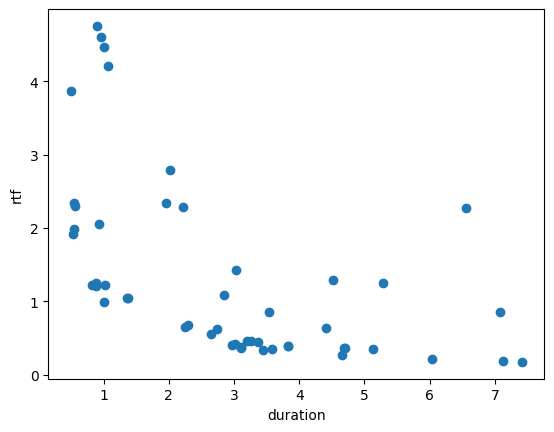

In [202]:
import seaborn as sns
# sns.regplot(data=dataset,
#             x="duration",
#             y="inf")
# # plt.ylim(0,2)
plt.scatter(data=dataset, x='duration', y='inf',)
plt.xlabel('duration')
plt.ylabel('rtf')
plt.show()


(array([0.50390584, 0.04319193, 0.10078117, 0.04319193, 0.01439731,
        0.        , 0.        , 0.        , 0.        , 0.01439731]),
 array([ 1.00128637,  2.39043478,  3.7795832 ,  5.16873161,  6.55788003,
         7.94702844,  9.33617686, 10.72532527, 12.11447369, 13.5036221 ,
        14.89277052]),
 <BarContainer object of 10 artists>)

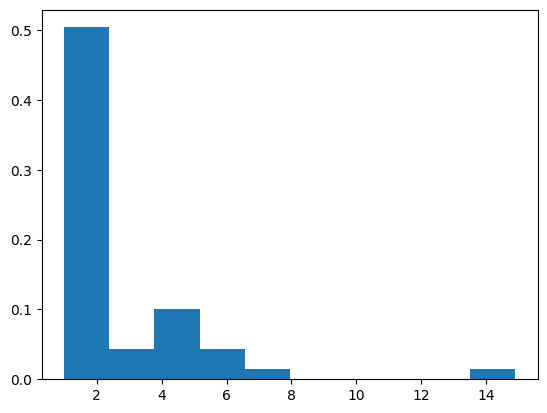

In [205]:
plt.hist(dataset['inf'], density=True)

In [87]:
import IPython

IPython.display.Audio(data=dataset[2], rate=22500)


In [46]:
rtf_data


,model,av_inf_time,av_duration,duration_std,av_RTF,RTF_std
0,tiny.en,1.755711,2.463612,1.606676,1.032647,0.971657
1,base.en,4.876610,2.463612,1.606676,3.253959,5.616636
2,small.en,13.352413,2.463612,1.606676,8.077425,10.379376
